In [1]:
import torch
import cv2
from PIL import Image
from pipeline import pipeline, segmentation_filter, user_palette_classification_filter, retrieval_filter
import torch.backends
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing, palette
import glob
import json

/Users/turey/Desktop/Dev/cis4000/backend/color-analysis/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/turey/Desktop/Dev/cis4000/backend/color-analysis/.venv/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
input_filename = 'da.jpg'
device = 'cpu' if torch.backends.mps.is_available() else 'cpu'
verbose = False
segmentation_model = 'cloud' # should be in ['local', 'cloud']
query = 'dress' # should be in ['dress', 'upper_body', 'lower_body']
n_plotted_retrieved_clothes = 50
print("Using device " + device)

Using device cpu


In [9]:
# setting paths
palettes_path = 'palette_classification/palettes/'
cloth_dataset_path = 'dresscode_test_dataset/'
palette_mappings_path = 'palette_classification/clothing_palette_mappings/'

# loading reference palettes for user palette classification filter
palette_filenames = glob.glob(palettes_path + '*.csv')
reference_palettes = [palette.PaletteRGB().load(
    palette_filename.replace('\\', '/'), header=True) for palette_filename in palette_filenames]

# loading palette mappings for retrieval filter
palette_mappings_dict = {}
for category in ['dresses', 'lower_body', 'upper_body']:
    mapping_dict_filename = palette_mappings_path + category + '/' + category + '_palette_mappings.json'
    with open(mapping_dict_filename) as mapping_dict_file:
        palette_mappings_dict[category] = json.load(mapping_dict_file)

# instantiating pipeline
pl = pipeline.Pipeline()

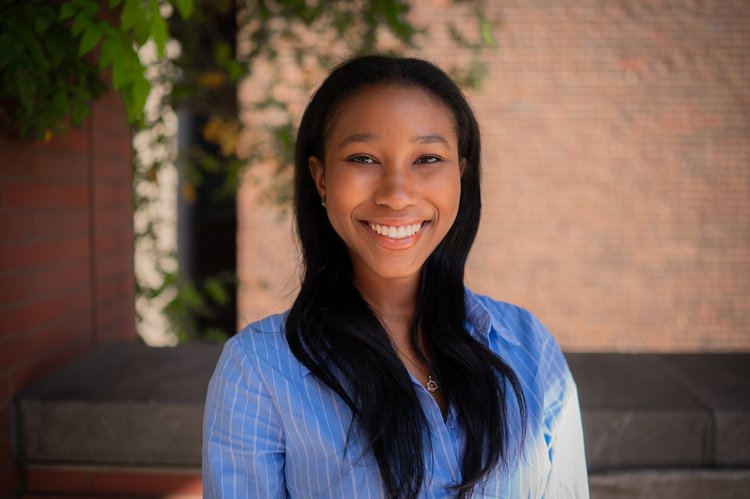

In [10]:
# loading input image
input = Image.open(input_filename).convert('RGB')
input

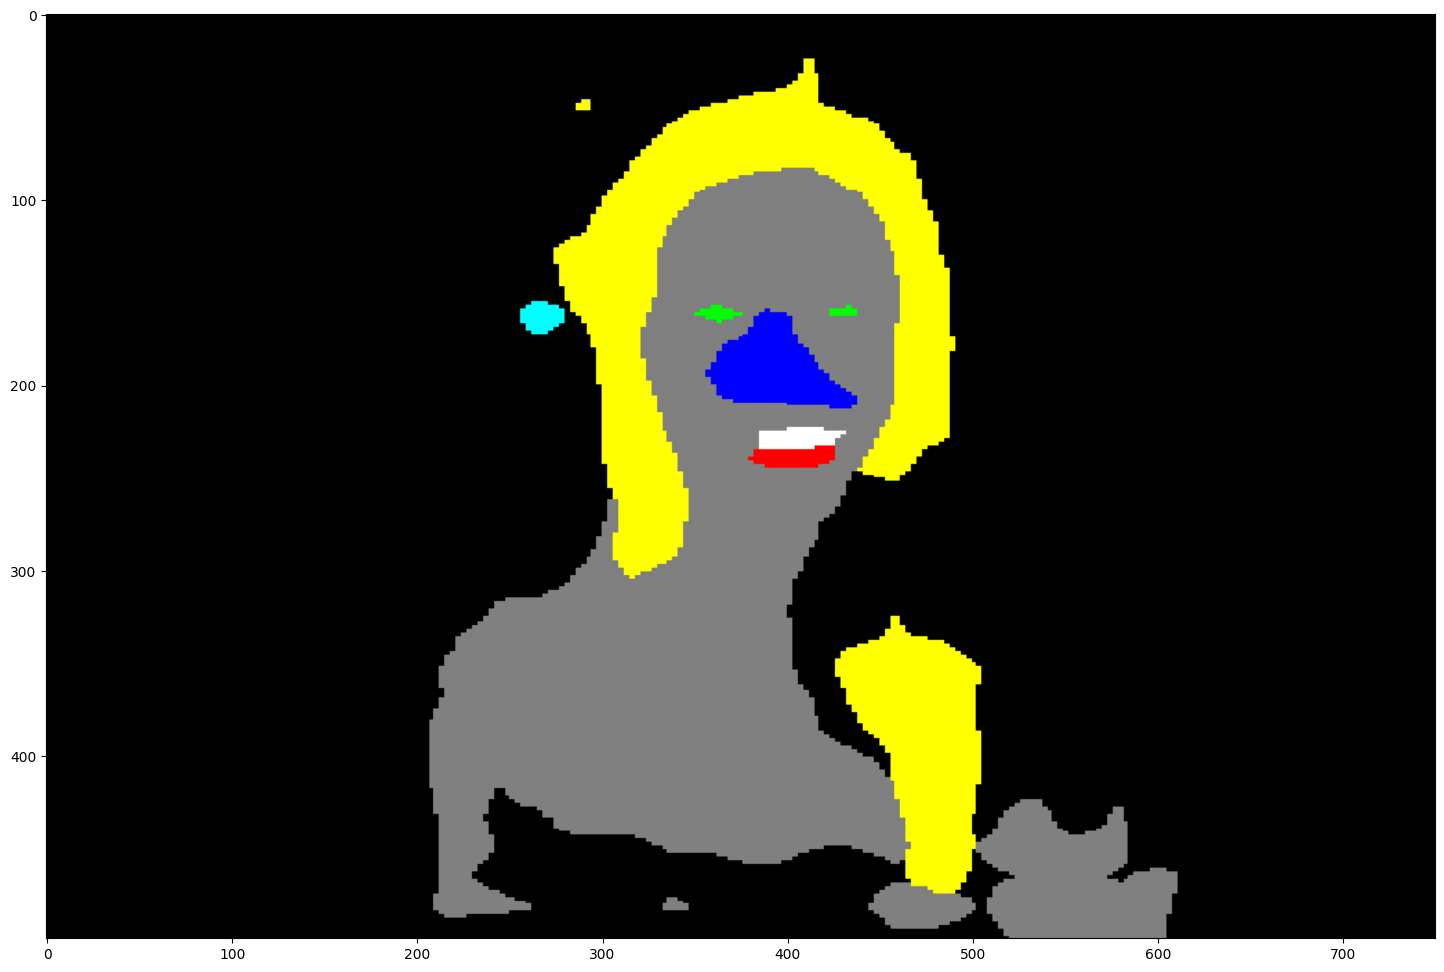

In [11]:
# adding segmentation filter
sf = segmentation_filter.SegmentationFilter(segmentation_model)
pl.add_filter(sf)

# executing pipeline: sf
img, masks = pl.execute(input, device, verbose)
img_segmented = color_processing.colorize_segmentation_masks(masks, segmentation_labels.labels)

# showing output of pipeline: sf
plt.figure(figsize=(20, 12))
plt.imshow(utils.from_DHW_to_HWD(img_segmented))

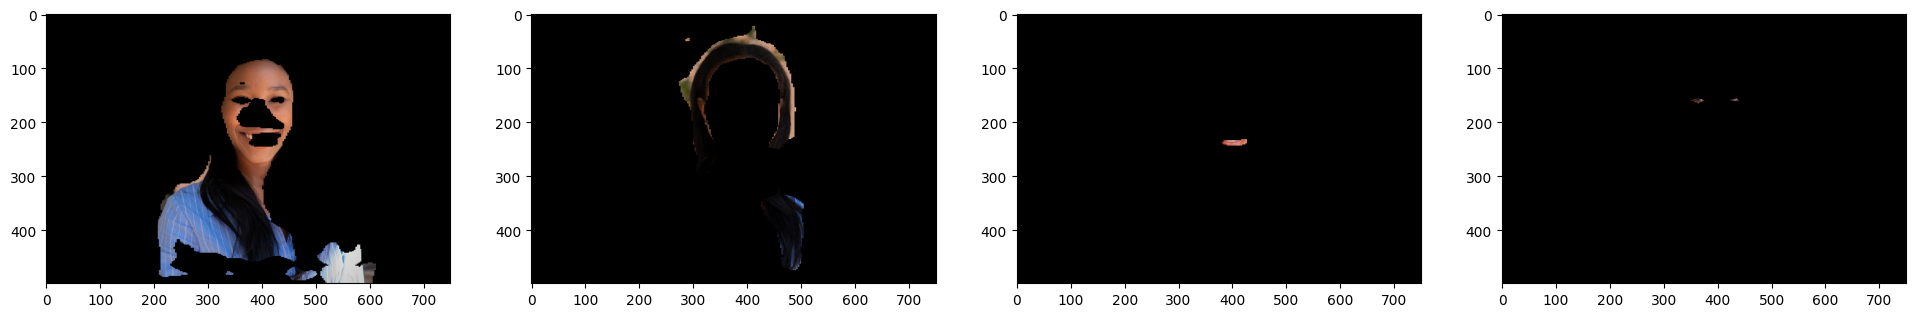

In [12]:
from typing import OrderedDict

labels = OrderedDict({ label: segmentation_labels.labels[label] for label in ['skin', 'hair', 'lips', 'eyes'] })

skin_idx = utils.from_key_to_index(labels, 'skin')
hair_idx = utils.from_key_to_index(labels, 'hair')
lips_idx = utils.from_key_to_index(labels, 'lips')
eyes_idx = utils.from_key_to_index(labels, 'eyes')

segmentation_masks = color_processing.compute_segmentation_masks(img_segmented, labels)
img_masked = color_processing.apply_masks(img, segmentation_masks)
plt.figure(figsize=(24, 14))
plt.subplot(1, 4, 1)
plt.imshow(utils.from_DHW_to_HWD(img_masked[0]))
plt.subplot(1, 4, 2)
plt.imshow(utils.from_DHW_to_HWD(img_masked[1]))
plt.subplot(1, 4, 3)
plt.imshow(utils.from_DHW_to_HWD(img_masked[2]))
plt.subplot(1, 4, 4)
plt.imshow(utils.from_DHW_to_HWD(img_masked[3]))
plt.show()

Candidate: (117,140,187), Weighted Reconstruction Error: 55.86328692706919


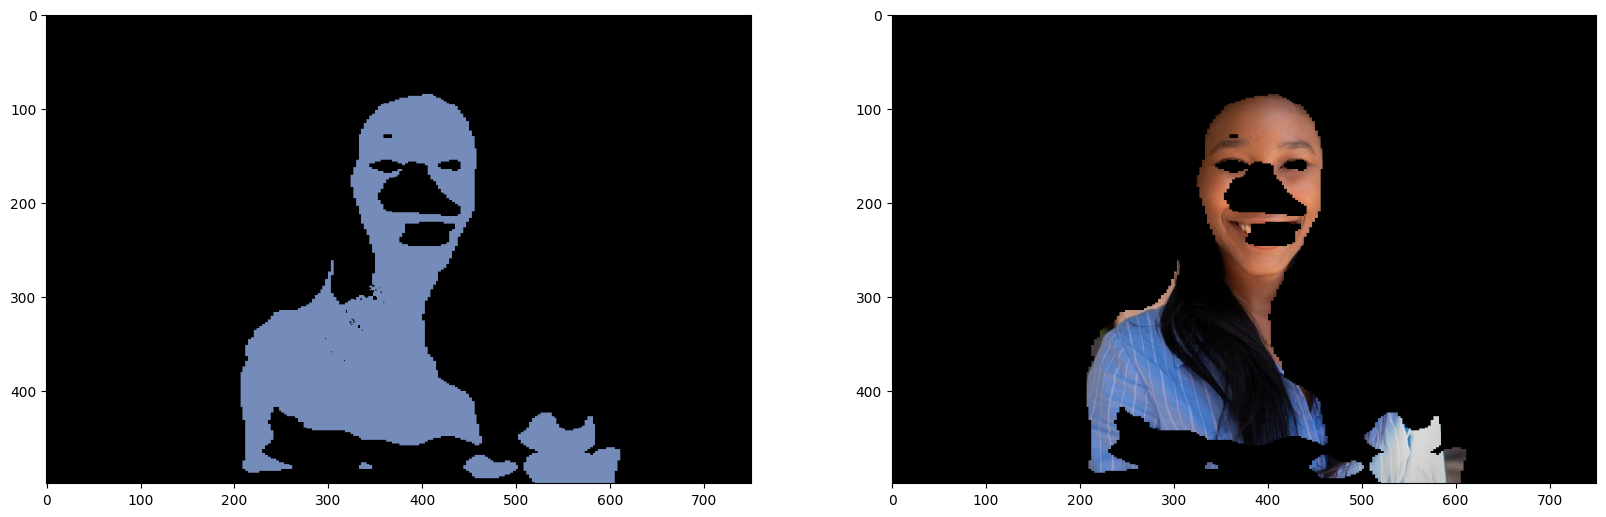

Candidate: (153,97,77), Weighted Reconstruction Error: 73.351458851729


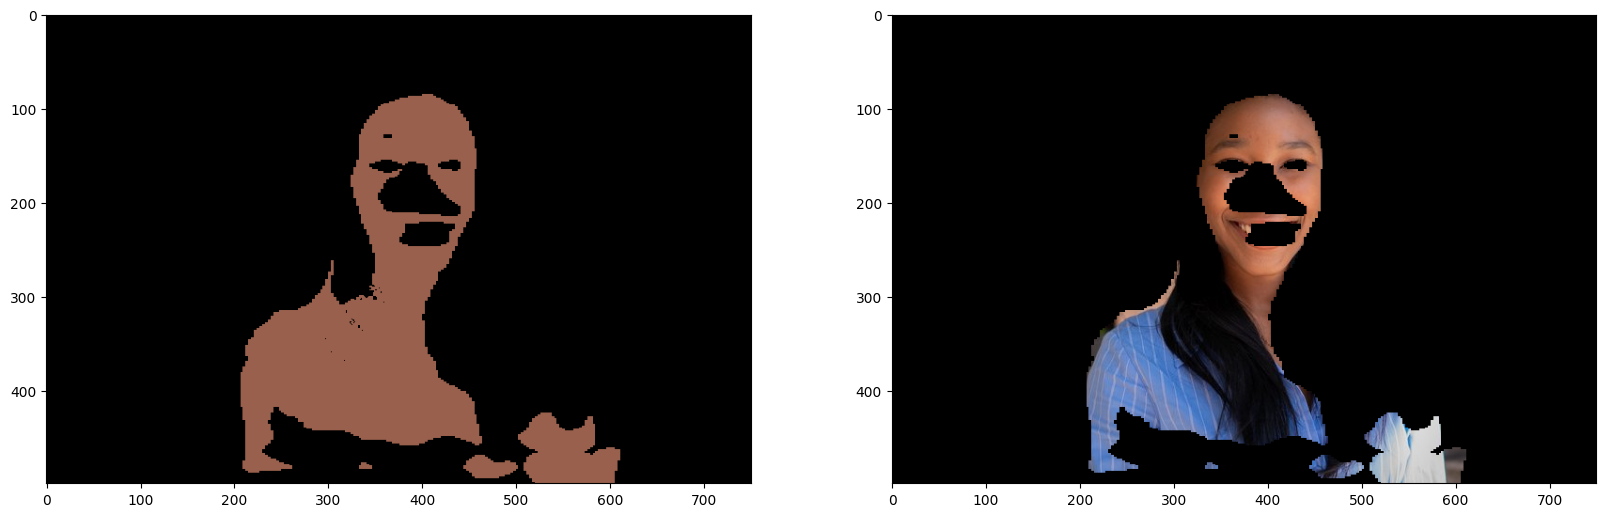

Candidate: (163,129,107), Weighted Reconstruction Error: 80.70258390285876


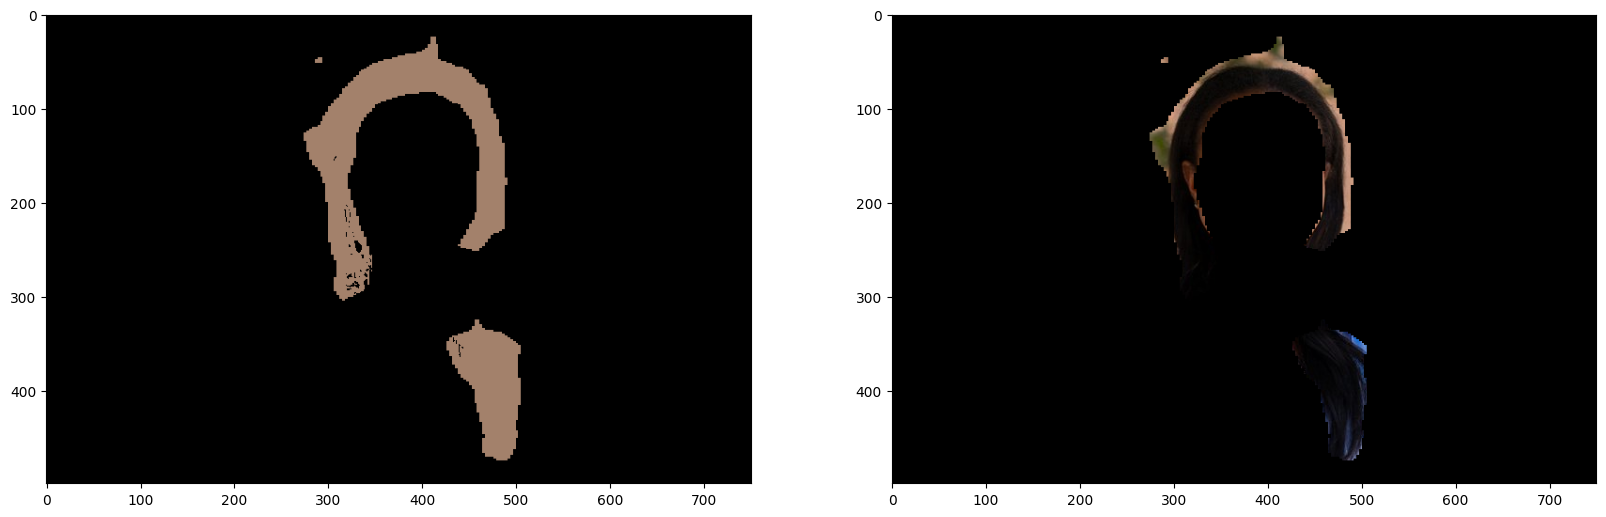

Candidate: (53,42,36), Weighted Reconstruction Error: 227.84453071008713


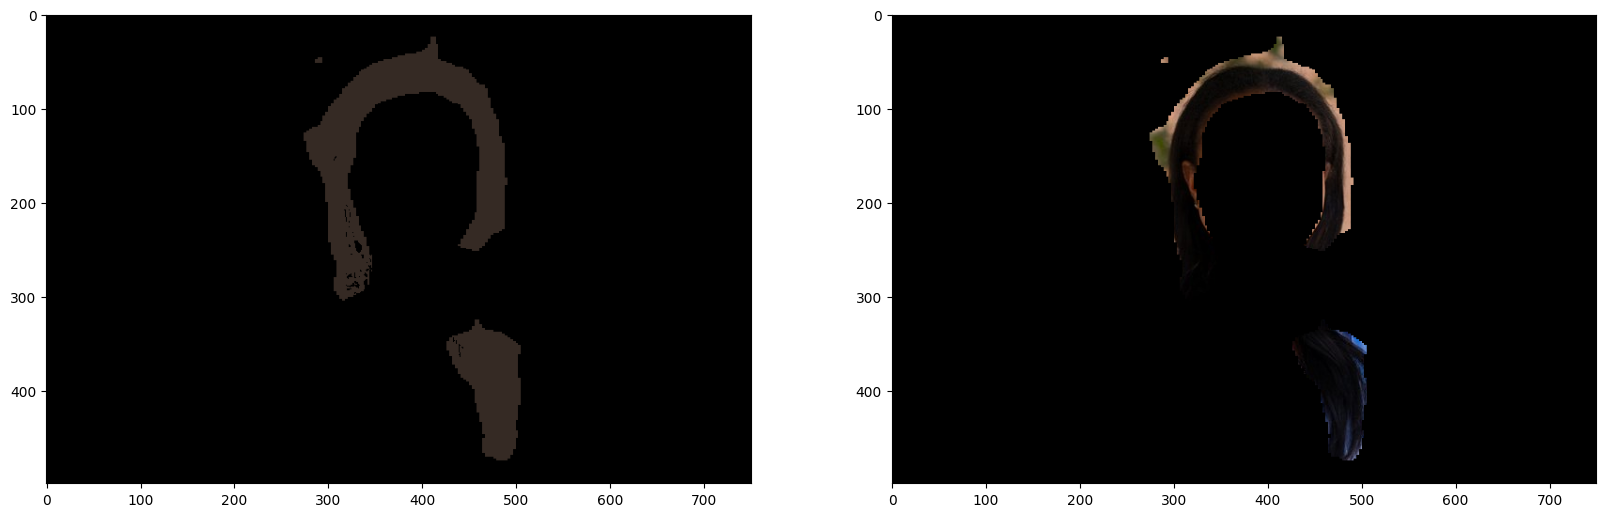

Candidate: (216,144,127), Weighted Reconstruction Error: 498.10198428041866


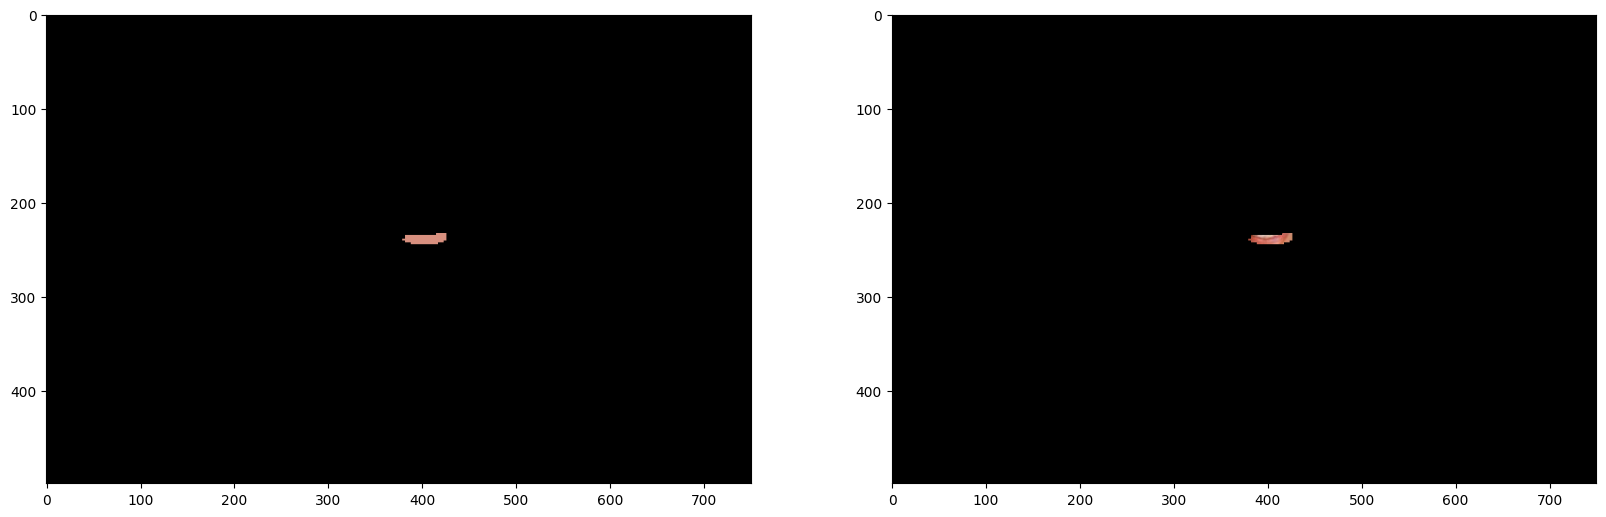

Candidate: (196,102,86), Weighted Reconstruction Error: 480.0856264455613


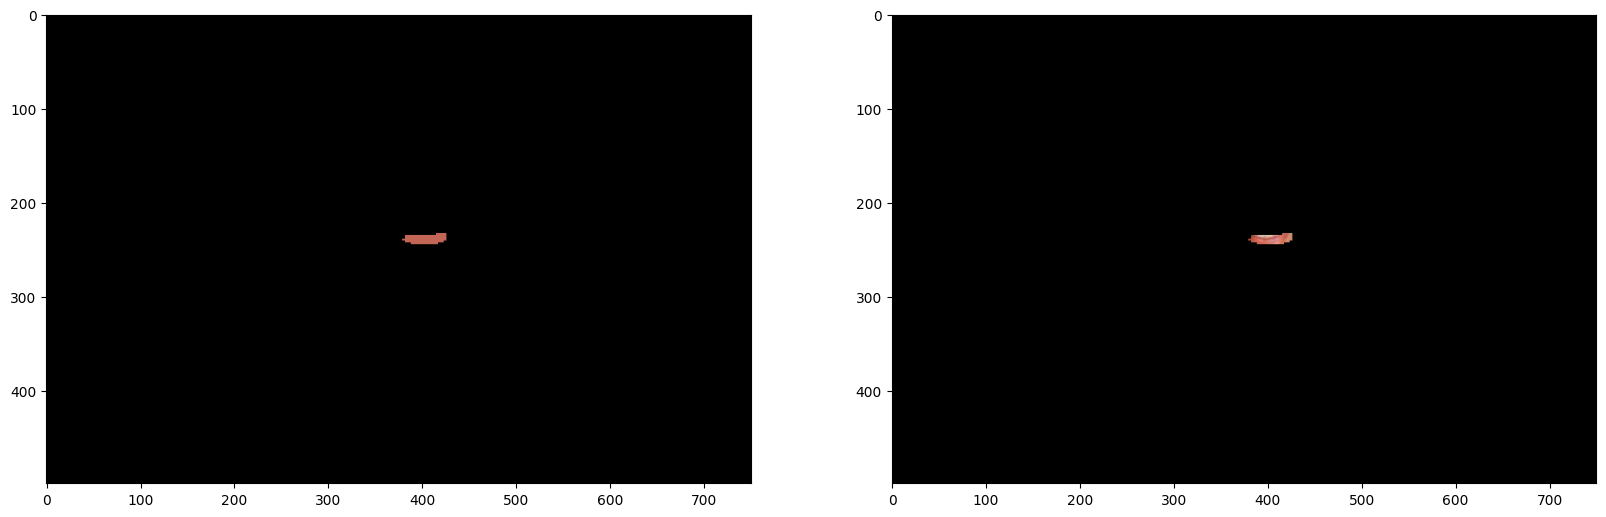

Candidate: (120,94,88), Weighted Reconstruction Error: 0.00010987445236413256


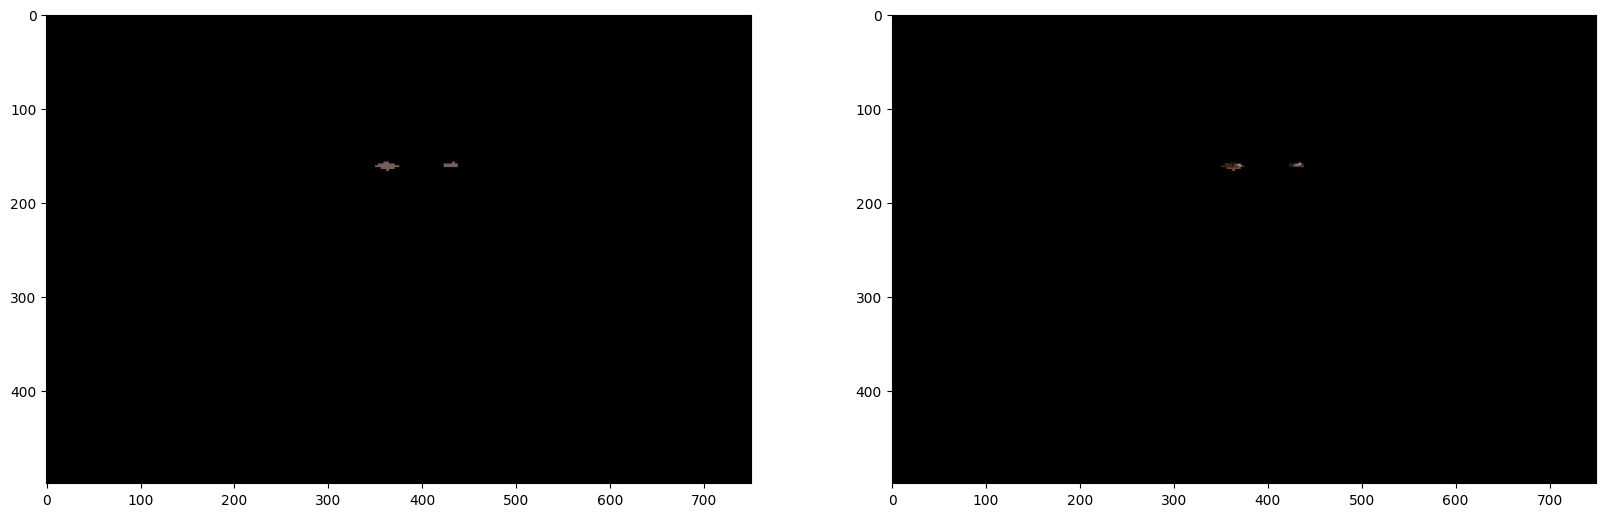

Candidate: (64,42,37), Weighted Reconstruction Error: 5.7216816452522115e-05


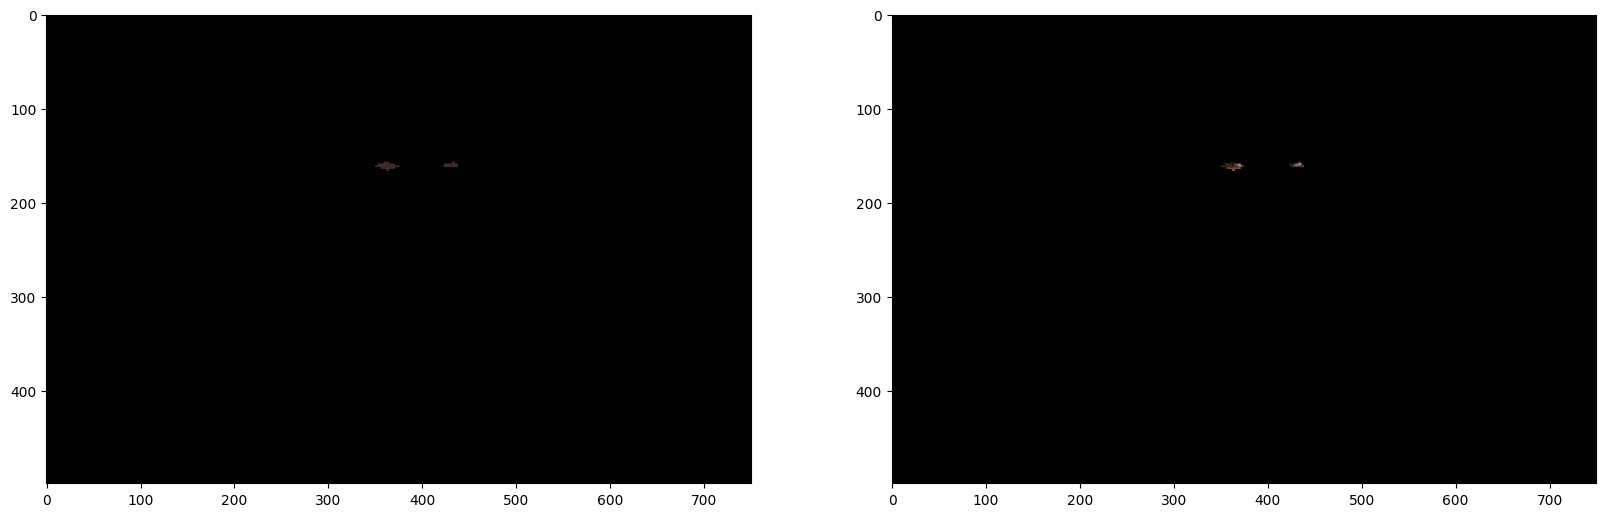

dominants


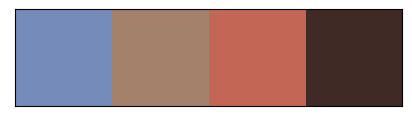

In [13]:
dominants = color_processing.compute_user_embedding(
    img_masked, n_candidates=(3, 3, 3, 3), distance_fn=metrics.rmse, debug=True)
dominants_palette = palette.PaletteRGB('dominants', dominants)
print(dominants_palette.description())
dominants_palette.plot()

In [102]:
# computing color harmony metrics and metrics_vector (see class palette.PaletteRGB)
thresholds = (0.200, 0.422, 0.390)
subtone = palette.compute_subtone(dominants[lips_idx])
intensity = palette.compute_intensity(dominants[skin_idx])
value = palette.compute_value(dominants[skin_idx], dominants[hair_idx], dominants[eyes_idx])
contrast = palette.compute_contrast(dominants[hair_idx], dominants[eyes_idx])
dominants_palette.compute_metrics_vector(subtone, intensity, value, contrast, thresholds)
print(f'metrics_vector: {dominants_palette.metrics_vector()}')

metrics_vector: tensor([0, 0, 1, 1], dtype=torch.uint8)


Season: summer
Subtone: cold 
Intensity: 0.38265299797058105 
Value: 0.6091503302256266 
Contrast: 0.4941176474094391


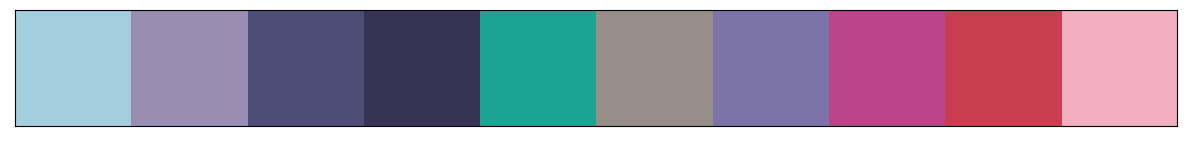

In [103]:
# Picking and assigning season which minimizes Hamming distance between metrics vectors, choosing 
# among seasons with same subtone
season_palette = palette.classify_user_palette(dominants_palette, reference_palettes)
print(f'Season: {season_palette.description()}')
print(f'Subtone: {subtone} \nIntensity: {intensity} \nValue: {value} \nContrast: {contrast}')
season_palette.plot(tile_size=15)

In [67]:
# executing pipeline: sf -> upcf
user_palette = pl.execute(input, device, verbose)

summer


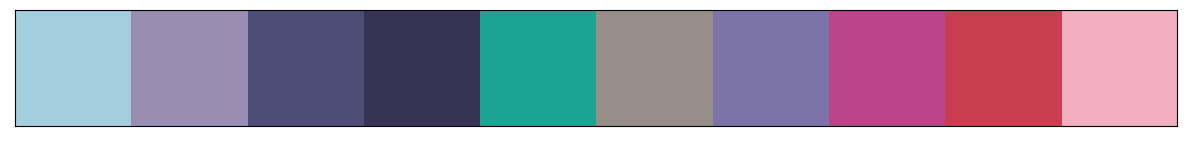

In [68]:
# # showing output of pipeline: sf -> upcf
print(user_palette.description())
user_palette.plot(tile_size=15)

In [ ]:
# adding retrieval filter
rf = retrieval_filter.RetrievalFilter(cloth_dataset_path, palette_mappings_dict)
rf.set_query(query)
pl.add_filter(rf)

In [ ]:
# executing pipeline: sf -> upcf -> rf
retrieved_clothes_paths = pl.execute(input, device, verbose)
n_retrieved_clothes = len(retrieved_clothes_paths)
print(f'Found {n_retrieved_clothes} clothes for query "{query}" and palette "{user_palette.description()}".')

Showing first 50 retrieved clothes.


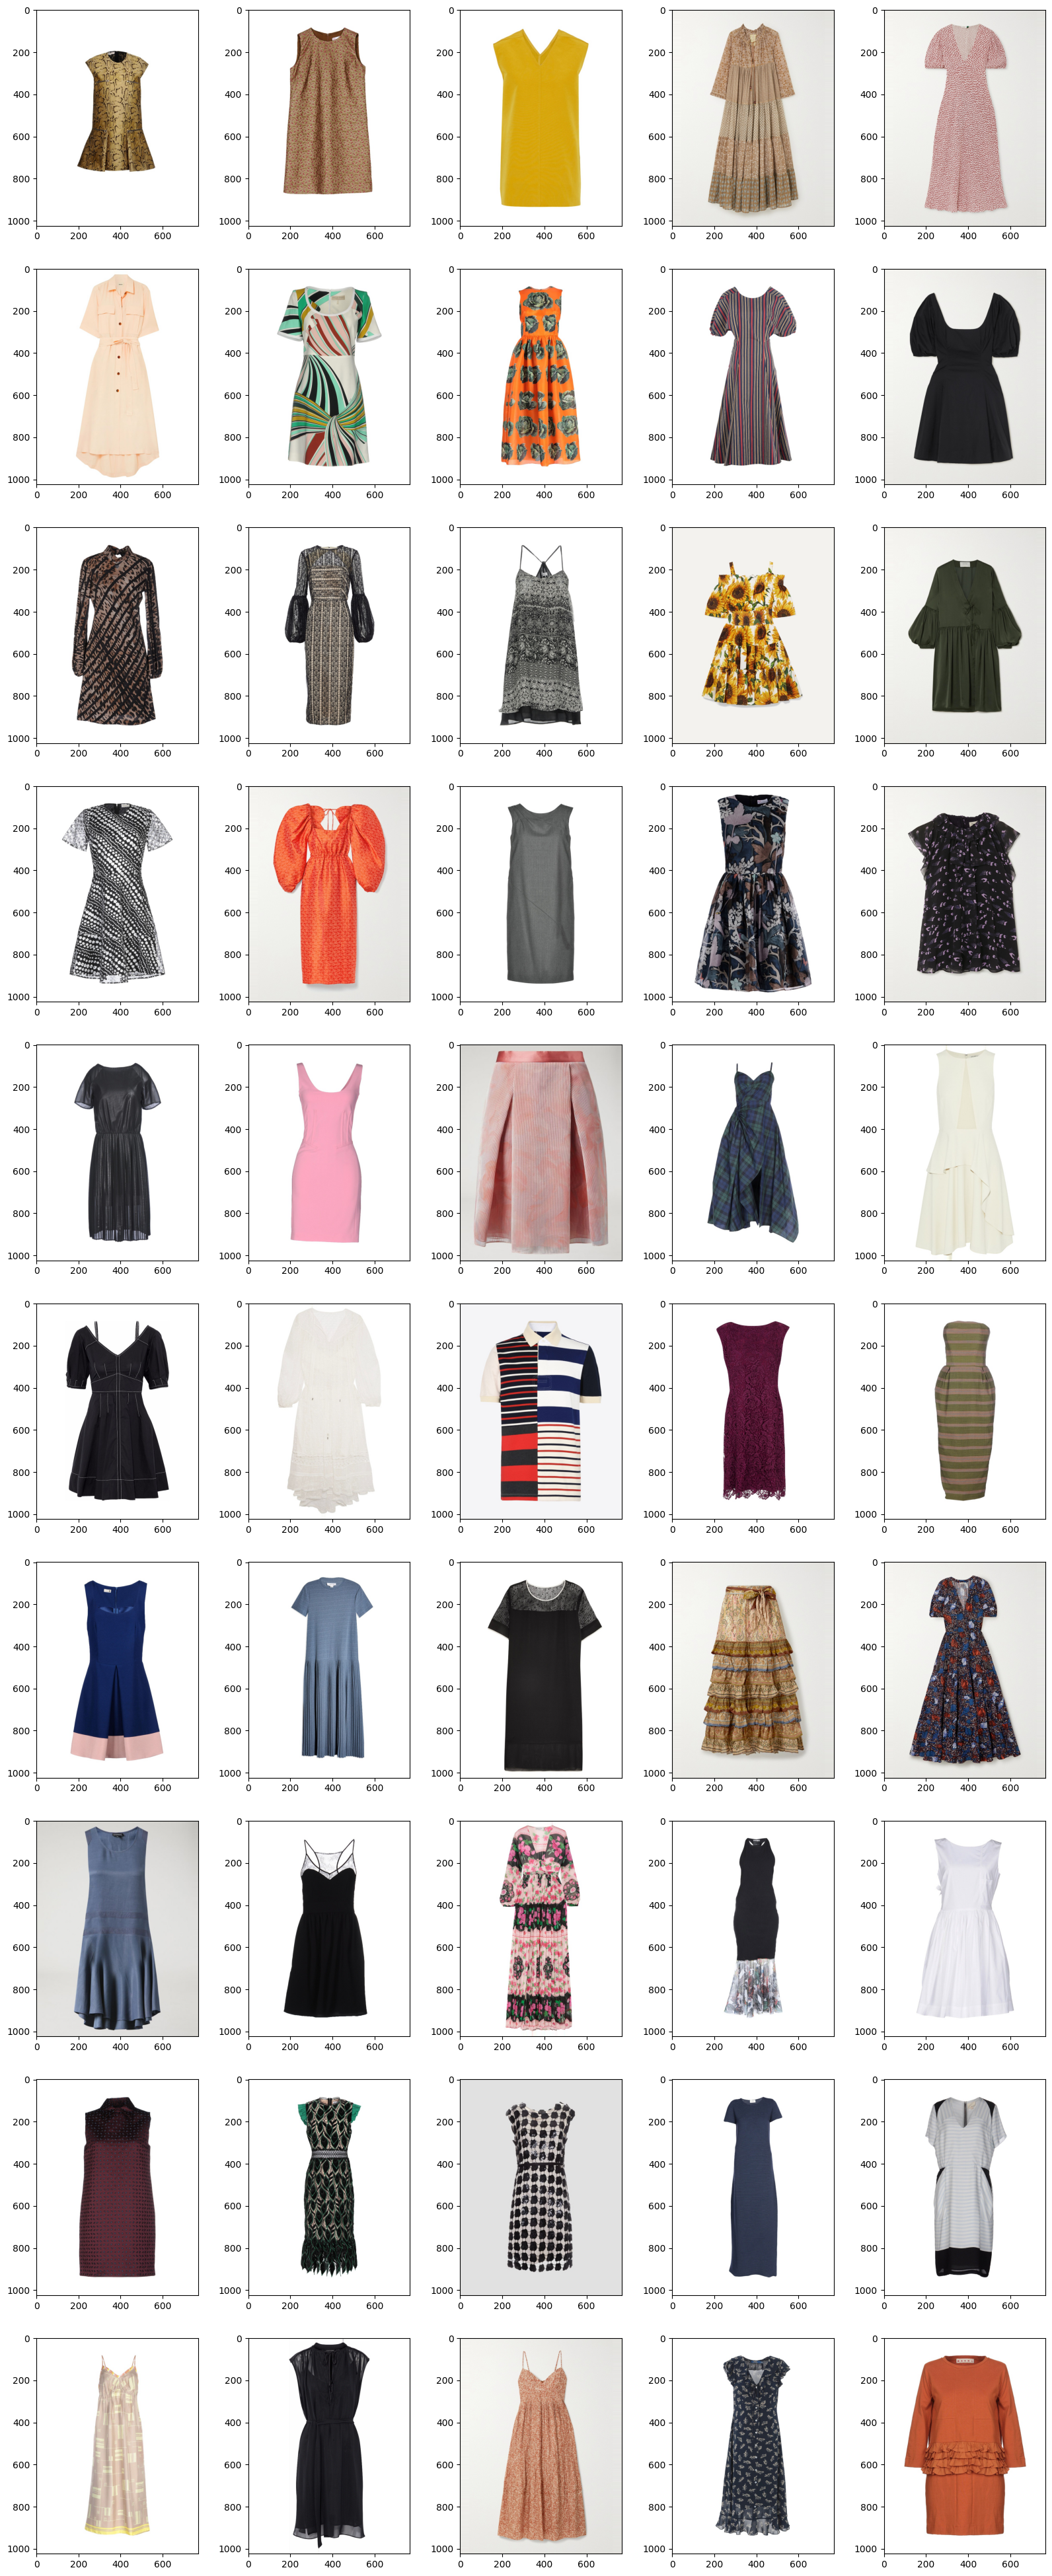

In [13]:
# plotting first n_plotted_retrieved_clothes outputs of pipeline: sf -> upcf -> rf
i = 1
n_columns = min(n_plotted_retrieved_clothes, 5)
n_rows = n_plotted_retrieved_clothes // n_columns
print(f'Showing first {n_plotted_retrieved_clothes} retrieved clothes.')
plt.figure(figsize=(20, 5 * n_rows))
for c in range(1, n_columns + 1):
    for r in range(1, n_rows + 1):
        plt.subplot(n_rows, n_columns, i)
        img = Image.open(retrieved_clothes_paths[i-1]).convert('RGB')
        plt.imshow(img)
        i += 1